In [28]:
# Import packages
import torch
import torchvision
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset 
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset
import torch.optim as optim
import time
import glob 
import numpy as np
import collada
from __future__ import print_function, division
import torch.nn as nn
from torch.autograd import Variable
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
# CONFIG #
# Adapted from Assignment 2 codebase

# TRAINING SETTINGS
NUM_EPOCHS = 10

# LEARNING RATE SETTINGS
BASE_LR = 0.001
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 7 # set the number of classes in your dataset
# DATA_DIR = 'CIFAR-10' # to run with the sample dataset, just set to 'hymenoptera_data'

# DATALOADER PROPERTIES
BATCH_SIZE = 50 # originally 10

# GPU SETTINGS
#TORCH_DEVICE = 'mps:0' # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
device = torch.device("mps")
GPU_MODE = 1 # set to 1 if want to run on gpu.

In [30]:
# Create a function to convert the directional metadata to unique IDs so it is easier to process later on
# Source: ChatGPT; generated with prompt: 'can you help me make a code that converts that vector into the following ids'

def vector_to_direction_id(vector):
    # If it's NaN, assign it class 6
    if pd.isna(vector):
        return 6

    # Clean the string (remove brackets, quotes, spaces)
    vector = str(vector).strip("[]'").replace(" ", "")

    direction_map = {
        '1\\,0\\,0': 0,   # x-up
        '-1\\,0\\,0': 1,  # x-down
        '0\\,1\\,0': 2,   # y-up
        '0\\,-1\\,0': 3,  # y-down
        '0\\,0\\,1': 4,   # z-up
        '0\\,0\\,-1': 5   # z-down
    }

    # Return the mapped direction or fallback to 6 (treat unknowns as NaN too)
    return direction_map.get(vector, 6)


# Example usage:
# vector = "['0\\,0\\,1']"
# direction_id = vector_to_direction_id(vector)
# print(f"The direction ID for {vector} is: {direction_id}")


In [31]:
# Import metadata to obtain object labels

metadata = pd.read_csv('/Users/ellacho/Documents/NB240/ShapeNetSem-backup/metadata.csv')

# Filter to select fullID and up

metadata_filtered = metadata[['fullId', 'up']].copy()

# Remove wss. prefix from full IDs 
# Source: https://www.reddit.com/r/learnpython/comments/ozacc3/how_do_i_remove_remove_stuff_like_from_a_string/
metadata_filtered['fullId'] = metadata_filtered['fullId'].str.replace('wss.', '')

# Change up to have unique IDs 
up_ID = np.zeros(len(metadata_filtered['up']))
for i in range(len(metadata_filtered['up'])):
    up_ID[i] = vector_to_direction_id(metadata_filtered['up'][i])

metadata_filtered['up'] = up_ID
# Create a dictionary
metadata_filtered_dict = metadata_filtered.set_index('fullId').T.to_dict('list')

In [32]:
# Get list of filenames in binvox png folder
# Source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

from os import listdir
from os.path import isfile, join

mypath = '/Users/ellacho/Documents/NB240/ShapeNetSem-backup/models_binvox_png'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# Remove suffix to get base name
onlyfiles_base = [file.removesuffix('.png') for file in onlyfiles]

In [33]:
import os
import glob
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

#DATA_DIR = '/Users/ellacho/Desktop/test'
DATA_DIR = '/Users/ellacho/Documents/NB240/ShapeNetSem-backup/models_binvox_png'

class ShapeNetSem(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.data_dir = DATA_DIR
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.target_transform = target_transform
        self.items = []

        for basefilename in onlyfiles_base:
            file_paths = glob.glob(f"{self.data_dir}/**/{basefilename}.png", recursive=True)
            for file_path in file_paths:
                if basefilename not in metadata_filtered_dict:
                    continue
                label = metadata_filtered_dict[basefilename]
                self.items.append((file_path, label))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, label = self.items[idx]
        
        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)  # Converts PIL image to a tensor

        # Convert label to a tensor
        
        label = torch.tensor(label, dtype=torch.long).squeeze()  # Ensure labels are long integers (used for classification)

        return image, label

In [34]:
# Define custom CNN

import torch.nn as nn
from collections import OrderedDict

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3,224,1)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.AvgPool2d(4)),
            ('conv2', nn.Conv2d(224,32,1)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.AvgPool2d(16)),
            ('flatten', nn.Flatten()),
            ('fc', nn.Linear(288,num_classes)),
        ]))

    def forward(self, x):
        return self.model(x).to(device)

In [35]:
use_gpu = GPU_MODE

In [36]:
# Define transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [37]:
# Define training and val datasets
full_dataset = ShapeNetSem()

In [38]:
# Generate train and val datasets
from torch.utils.data import random_split

# Define split sizes (80/20)
train_size = int(0.8*len(full_dataset))
val_size = len(full_dataset) - train_size

train_data, val_data = random_split(full_dataset, [train_size, val_size])

In [39]:
# Define dataset as dict
dsets = {}

dsets['train'] = train_data
dsets['val'] = val_data

In [40]:
# Define dataset loaders 

dset_loaders = {}
for split in ['train', 'val']:
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [41]:
# Define dset_sizes

dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}
print(dset_sizes)

{'train': 9829, 'val': 2458}


In [42]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model.to(device)
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter = 0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for data in dset_loaders[phase]:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # Set gradient to zero to delete history of computations in previous epoch
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Compute loss
                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch
                if counter % 10 == 0:
                    print(f"Reached batch iteration {counter}")

                counter += 1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update running loss and accuracy
                running_loss += loss.item() * inputs.size(0)  # Multiply by batch size for total loss
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.float() / dset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            accuracies[phase].append(epoch_acc.item())  # Store accuracy for the phase
            losses[phase].append(epoch_loss)  # Store loss for the phase

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                print(f'New best accuracy = {best_acc:.4f}')

        # Step the learning rate scheduler
        # lr_scheduler.step()
        optimizer = lr_scheduler(optimizer, epoch)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    print('Returning the best model')

    return best_model, accuracies, losses


In [43]:
# Define function for modifying learning rate

def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [44]:
# Define model architecture
model_ft = models.resnet50(pretrained=True)

criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.to(device)
    model_ft.to(device)

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.0001)

/opt/homebrew/Caskroom/miniforge/base/envs/NB240/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/NB240/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
# Run the functions and save the best model in the function model_ft.
model_ft, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

----------
Epoch 0/9
----------
LR is set to 0.001
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
Reached batch iteration 160
Reached batch iteration 170
Reached batch iteration 180
Reached batch iteration 190
train Loss: 0.8058 Acc: 0.7003
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
val Loss: 0.7210 Acc: 0.6965
New best accuracy = 0.6965
LR is set to 0.001
----------
Epoch 1/9
----------
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iterati

In [46]:
# Batch Size = 15, Epochs = 7

# torch.save(model_ft.state_dict(), 'shapenetsem_1.pt')

# Batch Size = 20, Epochs = 10
# torch.save(model_ft.state_dict(), 'shapenetsem_2.pt')

# Batch Size = 50, Epochs = 10 # ResNet50 instead of 18 to match the other models
torch.save(model_ft.state_dict(), 'shapenetsem_4.pt')

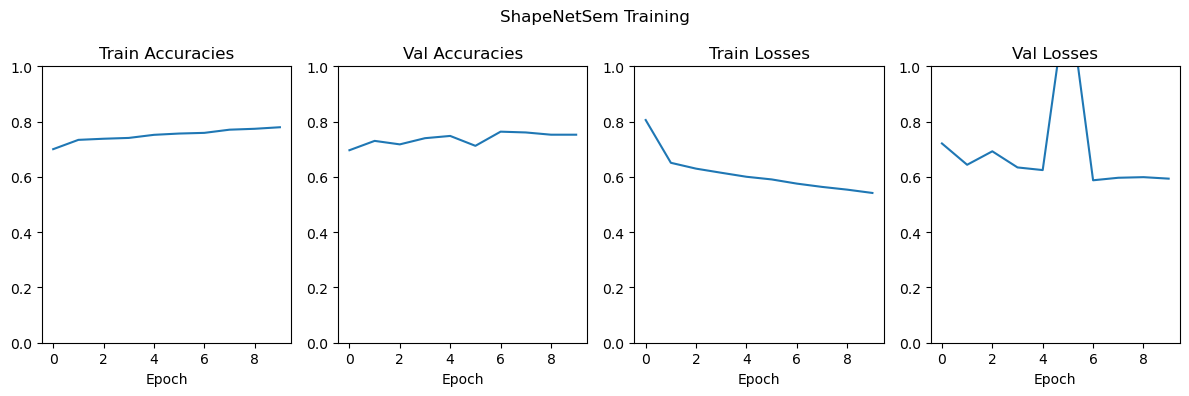

In [49]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("ShapeNetSem Training", fontsize=12) 

ax[0].plot(accuracies['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("ShapeNetSemTraining.png", dpi=300)

plt.show()